#  PTID-CDS-JUN22-1329

#  PRCP-1013-Walking and running classification

This dataset contains accelerometer and gyroscope data associated when a person is running and walking. The target is to create a LSTM model to predict the state of body from input of sensor. That's we have created a model that predicts if a person is walking or running based on the data from accelerometer and gyroscope from both left and right hands.

### Importing the libraries for data handling and representing the Data

In [1]:
!pip install tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aws-sam-cli 1.37.0 requires typing-extensions==3.10.0.0, but you have typing-extensions 3.7.4.3 which is incompatible.


  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.0
    Uninstalling typing-extensions-3.10.0.0:
      Successfully uninstalled typing-extensions-3.10.0.0


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil

import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Libraries required for the model

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neural_network import MLPClassifier

### Loading the Data

In [3]:
df = pd.read_csv('walkrun.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88588 entries, 0 to 88587
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            88588 non-null  object 
 1   time            88588 non-null  object 
 2   username        88588 non-null  object 
 3   wrist           88588 non-null  int64  
 4   activity        88588 non-null  int64  
 5   acceleration_x  88588 non-null  float64
 6   acceleration_y  88588 non-null  float64
 7   acceleration_z  88588 non-null  float64
 8   gyro_x          88588 non-null  float64
 9   gyro_y          88588 non-null  float64
 10  gyro_z          88588 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 7.4+ MB


In [5]:
print('The dataset contains ' + str(df.shape[0]) + ' data samples and ' + str(df.shape[1]) + ' data columns')

The dataset contains 88588 data samples and 11 data columns


In [6]:
df.isnull().sum()

date              0
time              0
username          0
wrist             0
activity          0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe()  ##statistical details of dataset

,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
count,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000
mean,0.522170,0.500801,-0.074811,-0.562585,-0.313956,0.004160,0.037203,0.022327
std,0.499511,0.500002,1.009299,0.658458,0.486815,1.253423,1.198725,1.914423
min,0.000000,0.000000,-5.350500,-3.299000,-3.753800,-4.430600,-7.464700,-9.480000
25%,0.000000,0.000000,-0.381800,-1.033500,-0.376000,-0.920700,-0.644825,-1.345125
50%,1.000000,1.000000,-0.059500,-0.759100,-0.221000,0.018700,0.039300,0.006900
75%,1.000000,1.000000,0.355500,-0.241775,-0.085900,0.888800,0.733700,1.398200
max,1.000000,1.000000,5.603300,2.668000,1.640300,4.874200,8.498000,11.266200


In [11]:
def findoutliers(column):
    outliers=[]
    Q1=column.quantile(.25)
    Q3=column.quantile(.75)
    IQR=Q3-Q1
    lower_limit=Q1-(1.5*IQR)
    upper_limit=Q3+(1.5*IQR)
    for out1 in column:
        if out1>upper_limit or out1 <lower_limit:
            outliers.append(out1)
            
    return np.array(outliers)

In [16]:
print("Outliers in acceleration_x:", len(findoutliers(df.acceleration_x)))
print("Outliers in acceleration_y:", len(findoutliers(df.acceleration_y)))
print("Outliers in acceleration_z:", len(findoutliers(df.acceleration_z)))

Outliers in acceleration_x: 11594
Outliers in acceleration_y: 1588
Outliers in acceleration_z: 12637


In [17]:
print("Number of outliers in gyro_x:", len(findoutliers(df.gyro_x)))
print("Number of outliers in gyro_y:", len(findoutliers(df.gyro_y)))
print("Number of outliers in gyro_z:", len(findoutliers(df.gyro_z)))

Number of outliers in gyro_x: 225
Number of outliers in gyro_y: 3004
Number of outliers in gyro_z: 134


<AxesSubplot:xlabel='acceleration_x'>

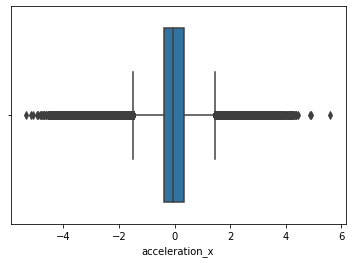

In [20]:
sns.boxplot(df.acceleration_x)

<AxesSubplot:xlabel='acceleration_y'>

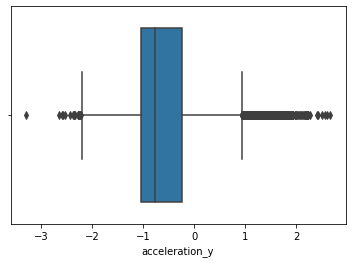

In [19]:
sns.boxplot(df.acceleration_y)

<AxesSubplot:xlabel='acceleration_z'>

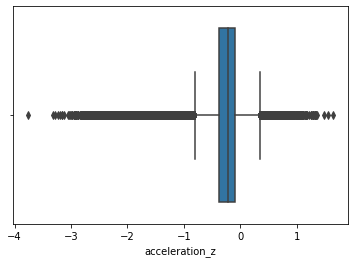

In [21]:
sns.boxplot(df.acceleration_z)

In [22]:
print('Dataset contains ' + str(pd.value_counts(df['activity'].values)[0]) + ' "walk" data samples as well as ' + str(pd.value_counts(df['activity'].values)[1]) + ' "run" data samples')

Dataset contains 44223 "walk" data samples as well as 44365 "run" data samples


In [23]:
print('The dataset contains ' + str(pd.value_counts(df['wrist'].values)[0]) + ' data samples collected on the left wrist as well as ' + str(pd.value_counts(df['wrist'].values)[1]) + ' data samples collected on the right wrist')

The dataset contains 42330 data samples collected on the left wrist as well as 46258 data samples collected on the right wrist


In [24]:
df.head(20)

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922
5,2017-6-30,13:51:17:46806991,viktor,0,0,0.4044,-0.8056,-0.0956,0.6925,-0.2179,2.5750
6,2017-6-30,13:51:17:246767997,viktor,0,0,0.6320,-1.1290,-0.2982,0.0548,-0.1896,0.4473
7,2017-6-30,13:51:17:446569025,viktor,0,0,0.6670,-1.3503,-0.0880,-0.8094,-0.7938,-1.4348
8,2017-6-30,13:51:17:646152973,viktor,0,0,0.2704,-0.8633,0.1293,-0.4173,-0.1904,-2.6759
9,2017-6-30,13:51:17:846502006,viktor,0,0,0.4690,-1.0740,0.0219,0.0388,1.1491,1.6982


In [25]:
LEFT_WRIST = 0
RIGHT_WRIST = 1

# populate dataframe with 'walk' data only
df_walk_data = pd.DataFrame()
df_walk_data = df[(df.activity == 0)]

# populate dataframe with 'run' data only 
df_run_data = pd.DataFrame()
df_run_data = df[(df.activity == 1)]

walk_data_left_wrist_count = pd.value_counts(df_walk_data['wrist'].values, sort=False)[LEFT_WRIST]
walk_data_right_wrist_count = pd.value_counts(df_walk_data['wrist'].values, sort=False)[RIGHT_WRIST]

run_data_left_wrist_count = pd.value_counts(df_run_data['wrist'].values, sort=False)[LEFT_WRIST]
run_data_right_wrist_count = pd.value_counts(df_run_data['wrist'].values, sort=False)[RIGHT_WRIST]

print('Total number of "walk" data samples: ' + str(len(df_walk_data)))
print('    Number of left wrist samples: ' + str(walk_data_left_wrist_count))
print('    Number of right wrist samples: ' + str(walk_data_right_wrist_count))
print('Total number of "run" data samples: ' + str(len(df_run_data)))
print('    Number of left wrist samples: ' + str(run_data_left_wrist_count))
print('    Number of right wrist samples: ' + str(run_data_right_wrist_count))

Total number of "walk" data samples: 44223
    Number of left wrist samples: 18622
    Number of right wrist samples: 25601
Total number of "run" data samples: 44365
    Number of left wrist samples: 23708
    Number of right wrist samples: 20657


In [26]:
DATA_COLUMNS = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z']

# populate dataframe with 'left' wrist only
df_left_wrist_data = pd.DataFrame()
df_left_wrist_data = df[df.wrist == 0]

# populate dataframe with 'right' wrist only
df_right_wrist_data = pd.DataFrame()
df_right_wrist_data = df[df.wrist == 1]

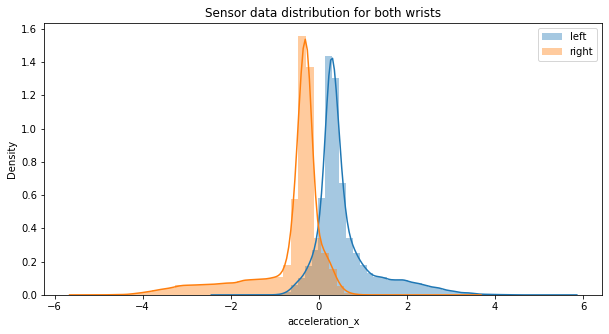

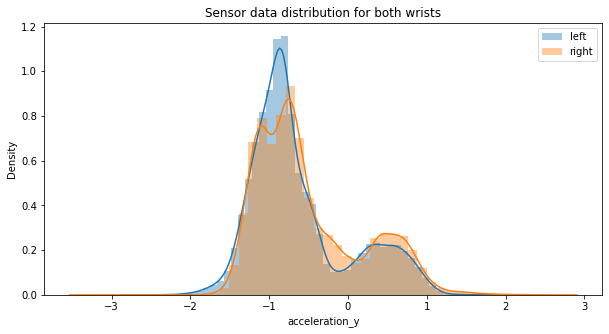

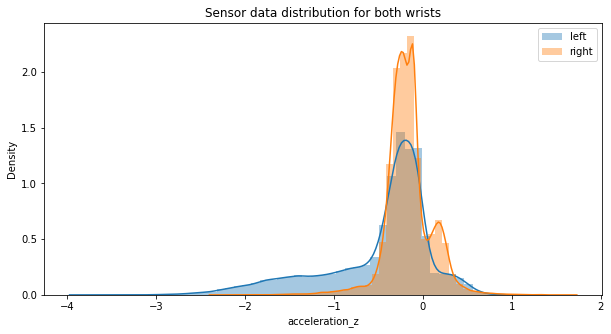

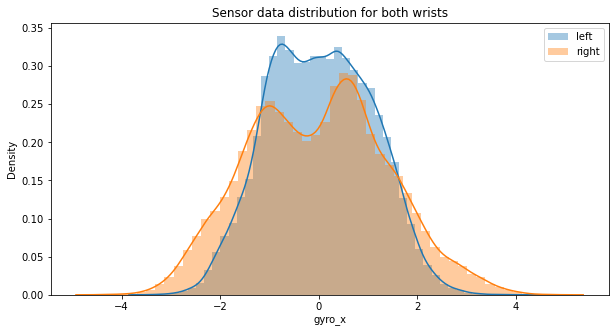

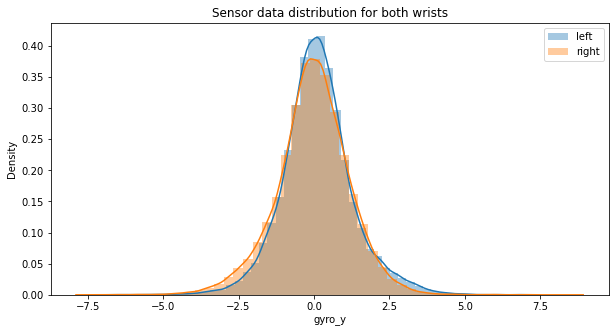

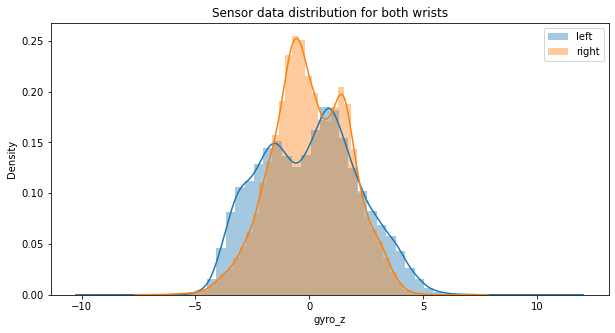

In [27]:
for c in DATA_COLUMNS:
    plt.figure(figsize=(10,5))
    plt.title("Sensor data distribution for both wrists")
    sns.distplot(df_left_wrist_data[c], label='left')
    sns.distplot(df_right_wrist_data[c], label='right')
    plt.legend()
    plt.show()

In [28]:
sns.set_theme(style="ticks")

from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

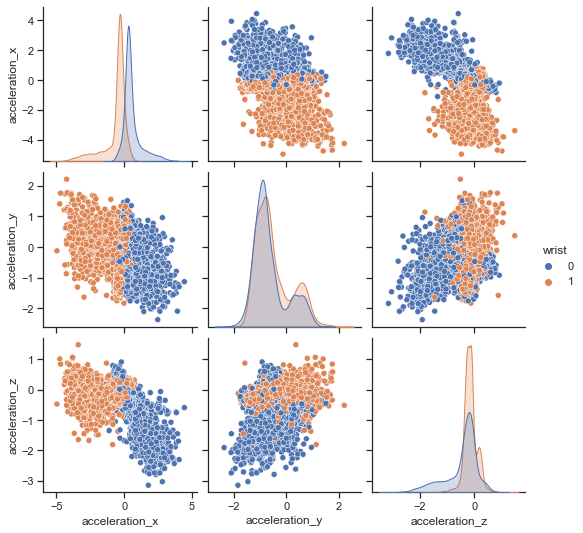

In [29]:
sns.pairplot(df[["acceleration_x", "acceleration_y", "acceleration_z", "wrist"]].sample(frac=.1).reset_index(drop=True), hue="wrist")

In [30]:
acceleration_df = df[["acceleration_x", "acceleration_y", "acceleration_z", "wrist", "activity"]].sample(frac=.1).reset_index(drop=True)

In [32]:
tsne = manifold.TSNE(n_components = 2, random_state=42)

transformed_data = tsne.fit_transform(acceleration_df[["acceleration_x", "acceleration_y", "acceleration_z", "wrist"]])

In [33]:
tsne_df = pd.DataFrame(
    np.column_stack((transformed_data, acceleration_df["activity"])),
    columns=["x", "y", "targets"]
)
    
tsne_df.loc[:, "targets"] = tsne_df.targets.astype(int)

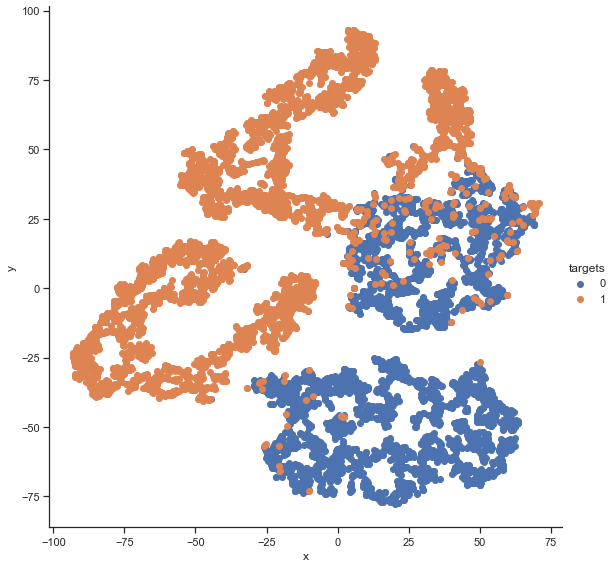

In [34]:
grid = sns.FacetGrid(tsne_df, hue="targets", size=8)
grid.map(plt.scatter, "x", "y").add_legend()

<AxesSubplot:>

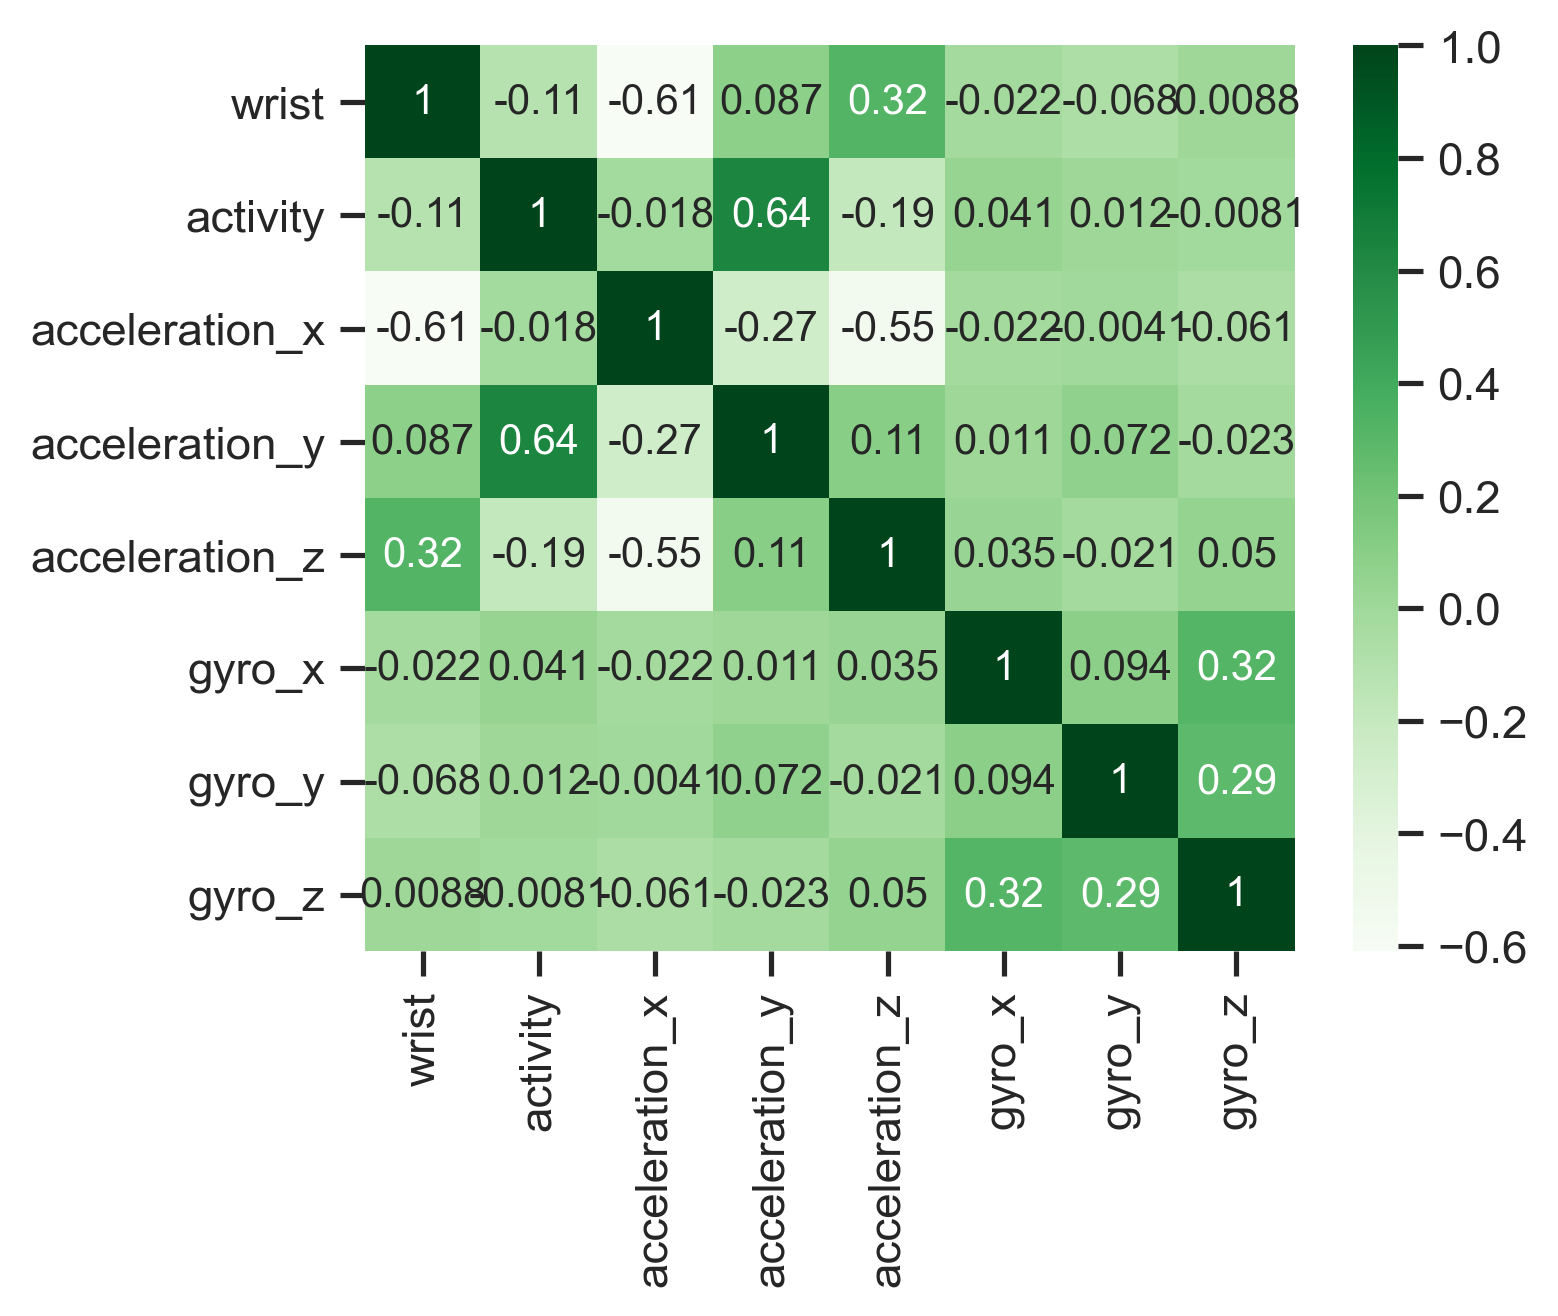

In [46]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,4), dpi = 300)

# Plot Heatmap

sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="Greens")

In [47]:
y = df["activity"].to_numpy()
x = df[["acceleration_x", "acceleration_y", "acceleration_z", "wrist", "gyro_x", "gyro_y", "gyro_z"]].to_numpy()

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33)

In [49]:
def create_baseline():
    model = keras.Sequential(
    [
        layers.Dense(14, input_shape = (None,7), activation="relu"),
        layers.Dense(20, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(5, activation="relu"),
        layers.Dense(1,  activation="sigmoid"),
    ]
    )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [50]:
model = create_baseline()

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 14)          112       
_________________________________________________________________
dense_1 (Dense)              (None, None, 20)          300       
_________________________________________________________________
dense_2 (Dense)              (None, None, 10)          210       
_________________________________________________________________
dense_3 (Dense)              (None, None, 5)           55        
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           6         
Total params: 683
Trainable params: 683
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(x_train, y_train, batch_size=128, epochs=15)

Epoch 1/15
464/464 [==============================] - 4s 1ms/step - loss: 0.2608 - accuracy: 0.8862
Epoch 2/15
464/464 [==============================] - 1s 2ms/step - loss: 0.0505 - accuracy: 0.9837: 1s - loss: 0
Epoch 3/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0378 - accuracy: 0.9878
Epoch 4/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0326 - accuracy: 0.9896
Epoch 5/15
464/464 [==============================] - 0s 1ms/step - loss: 0.0302 - accuracy: 0.9904
Epoch 6/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0288 - accuracy: 0.9906
Epoch 7/15
464/464 [==============================] - 0s 1ms/step - loss: 0.0278 - accuracy: 0.9912
Epoch 8/15
464/464 [==============================] - 0s 1ms/step - loss: 0.0267 - accuracy: 0.9913
Epoch 9/15
464/464 [==============================] - 0s 1ms/step - loss: 0.0264 - accuracy: 0.9910
Epoch 10/15
464/464 [==============================] - 0s 1ms/step - loss: 0.0257 - ac

In [52]:
model = MLPClassifier()
model.fit(x_train,y_train)
y_predict=model.predict(x_test)
accuracy_score(y_test,y_predict)

0.9920301009064477

### CONCLUSIONS:
 - The dataset analyzed in this notebook can be considered as a high quality one since it properly formatted, delivers clear values and doesn't contain NaN values.
 - Regarding the sensor data presented in the dataset, one can make a conclusion that the data presented doesn't suffer from skewing and normally distributed.